# Does the inclusion of cryptocurrency-based indicies extend the MV frontier of a well diversified equity investor?

*In this project we will investigate if cryptocurrencies extend the mean-variance frontier of an equity investor. By using an industry portfolio dataset consisting of 12 different industries collected from Kenneth French data library combined with the 3 largest cryptocurrencies based on market capitalization, we extract the mean-variance frontier. We show that adding cryptocurrencies to the mean-variance frontier has a significant impact.*

<span style="color:crimson"> **NOTE**</span> \
Please make sure you have run the [src/data/make_dataset.py](../src/data/make_dataset.py) in order to reproduce our results. Also note that you need to be in the */src/data* folder to be able to run that script. To use own data, please see instructions in [README](../README.md#data-grabbing). 

## Describing functions used to compute the efficient frontier


The following functions are located in [utility_functions.py](../src/features/utility_functions.py) in the [/src/features](../src/features/) directory.

#### `annualize_rets(r, preiods_per_year)`
This function annualizes a set of return series by calculating the compounded growth of the returns and then converting it to an annualized rate, adjusting for the number of periods in a year. 
* `r`: The input returns as a pandas Series or DataFrame.
*  `periods_per_year`: The number of return periods in a year (e.g., 252 for daily returns, 12 for monthly returns).


$$ \text{Annualized Return} = \left( \prod_{i=1}^{n} (1 + r_i) \right)^{\frac{\text{periods\_per\_year}}{n}} - 1 $$

#### `annualize_vol(r, periods_per_year)` 
This function annualizes the volatility of a set of returns.
* `r`: The input returns as a pandas Series or DataFrame.
*  `periods_per_year`: The number of return periods in a year (e.g., 252 for daily returns, 12 for monthly returns).
$$ \text{Annualized Volatility} = \text{Standard Deviation of Returns} \times \sqrt{\text{Number of Periods per Year}} $$

#### `sharpe_ratio(r, riskfree_rate, periods_per_year)`

This function computes the annualized sharpe ratio representing the risk-adjusted performance of each of the included portfolios. Additionally it takes the above-defined annual risk-free rate as a paramater and converts it to correspond to each trading day. 

   $$ \text{rf\_per\_period} = (1 + \text{riskfree\_rate})^{(1/\text{periods\_per\_year})} - 1 $$

   $$ \text{Sharpe Ratio} = \frac{\text{ann\_ex\_ret}}{\text{ann\_vol}} $$

#### `minimize_vol(target_return, er, cov)`
This function takes as inputs the set of expected returns and a corresponding covariance matrix and returns a set of optimized portfolio weights that achieve the target return, by using the `scipy.optimize.minimize` function which takes as the objective function the `portfolio_vol`. The optimization method chosen is the Sequential Least Squares Programming (SLSQP) which iteratively solves a bunch of quadratic subproblems until it converges to a solution that satisfies the imposed conditions. The general optimization problem looks like this:

$$\begin{align*}
\min \quad & f(x) \\
\text{s.t.} \quad & \left\{ \begin{array}{ll}
g_i(x) = 0, & \text{for all } i \in \text{equality constraints} \\
g_i(x) \geq 0, & \text{for all } i \in \text{inequality constraints}
\end{array} \right.
\end{align*}$$

##### `optimal_weights(n_points, er, cov):`
This function generates a set of target returns evenly spaced between the minimum and maximum expected returns in the inputed series of expected returns using `numpy.linspace`. 

For each target return in the above set it calls the above defined `minimize_vol` to find the optimal weights for a portfolio that achieves corresponding target return

##### `portfolio_vol(weights, covmat)`
This function calculates the portfolio volatility using the following linear algebra expression:
$$ \text{Portfolio Volatility} = \sqrt{ \mathbf{w}^T\Sigma \c\mathbf{w} } $$

Where:
* $ \mathbf{w} \ $ is the column vector of weights computed in the function above.
* $ \Sigma $ is the covariance matrix of returns.

##### `portfolio_return(weights, returns)`
This function computes the return of a portfolio, given the weights and returns, both in the form of a numpy array.

$$ \text{Portfolio Return} = \mathbf{w}^T\mathbf{r} $$


## Computing the mean variance frontier

<span style="color:crimson"> **NOTE**</span> \
Please make sure you have run the [src/data/make_dataset.py](../src/data/make_dataset.py) in order to reproduce our results. Also note that you need to be in the */src/data* folder to be able to run the script. To use own data, please see instructions in [README](../README.md#data-grabbing). 

### Loading libraries and data

In [1]:
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy 
import scipy.optimize as opt
import sys
import textwrap # Do we really need this? maybe just make a sub title?


sys.path.append('../src')
import features.utility_functions as util
import visualization.plotting_functions as plotting_functions
from data.config import TICKERS_CRYPTO # importing the list of crypto currencies from config.py

In [2]:
ind_crypto = pd.read_csv('../data/processed/industry_crypto_returns.csv', parse_dates=True, index_col='Date')

# defining lists of assets used later in optmizer:
industry_and_crypto = ind_crypto.columns.values.tolist()
industry = [item for item in industry_and_crypto if item not in TICKERS_CRYPTO]

### Summary statistics of different portfolios and included instruments

In [3]:
ind_crypto.describe()

,NoDur,Durbl,Manuf,Enrgy,Chems,BusEq,Telcm,Utils,Shops,Hlth,Money,Other,BTC-USD,ETH-USD,XRP-USD
count,1480.000000,1480.000000,1480.000000,1480.000000,1480.000000,1480.000000,1480.000000,1480.000000,1480.000000,1480.000000,1480.000000,1480.000000,1480.000000,1480.000000,1480.000000
mean,0.000278,0.000409,0.000533,0.000823,0.000483,0.000615,0.000120,0.000342,0.000590,0.000210,0.000406,0.000474,0.001941,0.002846,0.003418
std,0.013419,0.018021,0.016582,0.029664,0.016406,0.016811,0.016447,0.013238,0.016897,0.018203,0.015313,0.015111,0.045450,0.058645,0.079164
min,-0.107600,-0.119700,-0.119800,-0.262000,-0.111100,-0.116100,-0.116200,-0.117400,-0.137000,-0.122000,-0.127200,-0.139200,-0.371695,-0.423472,-0.423340
25%,-0.006500,-0.009300,-0.008100,-0.014625,-0.008700,-0.007700,-0.008600,-0.005225,-0.008300,-0.010025,-0.006400,-0.006300,-0.017276,-0.023467,-0.026419
50%,0.000500,0.000200,0.000700,0.000150,0.000800,0.001350,0.000200,0.000700,0.000500,0.000950,0.000200,0.000700,0.000942,0.000470,-0.000737
75%,0.006900,0.009900,0.009200,0.016050,0.009700,0.009700,0.008825,0.006400,0.008900,0.010425,0.007100,0.007500,0.021195,0.029656,0.025058
max,0.088100,0.107500,0.101100,0.226700,0.076900,0.095100,0.086200,0.125400,0.124600,0.086800,0.098200,0.107300,0.252472,0.409905,0.871502


### Plotting the variance-covariance matrix of returns in heat-map form

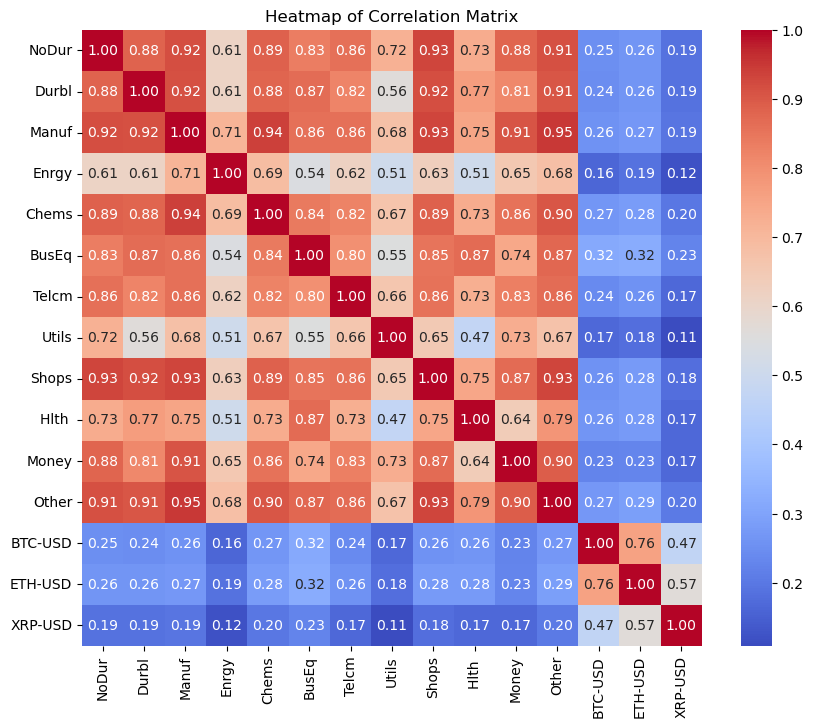

In [4]:
plt.figure(figsize=(10, 8))

sns.heatmap(ind_crypto.corr(), annot=True, fmt=".2f", cmap='coolwarm')

plt.title("Heatmap of Correlation Matrix")
plt.savefig("../Reports/Figures/heatmap_correlation.png")
plt.show()

### Computing & plotting the sharpe ratios of all instruments

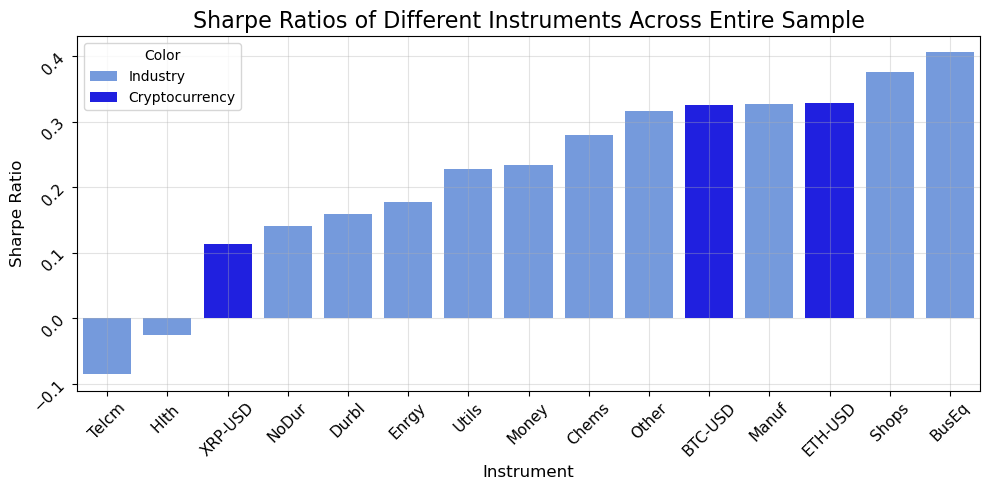

In [5]:
# Parameters:
rf = 0.019 # Risk-free rate 
periods_per_year = 260 # Number of trading days per year

# Calculating sharpe ratios
industry_SR = util.sharpe_ratio(ind_crypto, rf, periods_per_year).sort_values()

# converting to pd dataframe for seaborne compatability
df = industry_SR.to_frame('Sharpe Ratio') 
colors = ['Cryptocurrency' if item in TICKERS_CRYPTO else 'Industry' for item in df.index] 
df['Color'] = colors

plt.figure(figsize=(10, 5))
sns.barplot(x=df.index, y='Sharpe Ratio', hue='Color', data=df, palette=["cornflowerblue", "blue"])

plt.title('Sharpe Ratios of Different Instruments Across Entire Sample', fontsize=16)
plt.xlabel('Instrument', fontsize=12)
plt.ylabel('Sharpe Ratio', fontsize=12)

plt.xticks(rotation=45, fontsize=11)
plt.yticks(rotation=45, fontsize=11)

plt.grid(True, alpha=0.35)

plt.tight_layout()
plt.savefig("../Reports/Figures/SR_Entire_Sample.png")
plt.show()


### Defining a function that plots 2 efficient frontiers given the return data

### Plotting the efficient frontiers

Timeframes plot limits for 3 different market timeframes to facilitate reproducibility. 
* The desired dates corresponding to different timeframes are to be inputed as the index range of the dataframe ind_crypto which results in the computational process to only consider the desired data.
* The axis limits are to be inputed as arguments inside the plot_ef function
- **Full sample** 
    - Period: '2017-10-31':'2023-10-31'
    - xlim=(0.0114, 0.015),
    - ylim=(0.055, 0.12)
- **Equity bull market**
    - Period: '2017-10-31':'2021-12-1'
    - xlim=(0.0125, 0.0155),
    - ylim=(0.155, 0.3)
- **High volatility equity market with large negative drawdowns**
    - Period: '2021-12-1':'2023-10-31'
    - xlim=(0.0075, 0.025),
    - ylim=(0.0, 0.35)

#### Plotting frontier with full sample

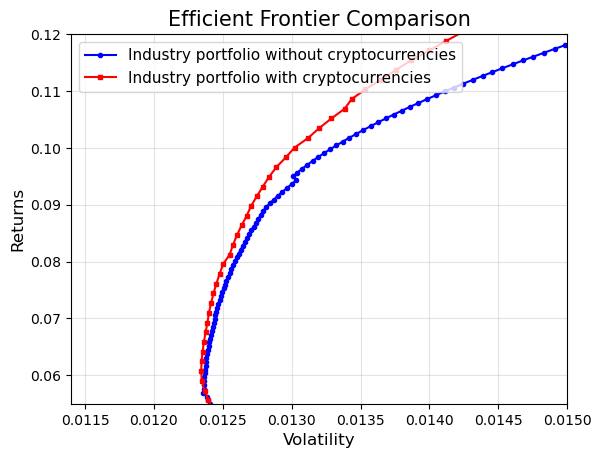

In [6]:
ind_crypto_spliced = ind_crypto['2017-10-31':'2023-10-31']

er = util.annualize_rets(ind_crypto_spliced, periods_per_year)
cov = ind_crypto_spliced.cov()

plot = plotting_functions.plot_ef(
er[industry], cov.loc[industry, industry], 
er[industry_and_crypto], 
cov.loc[industry_and_crypto, industry_and_crypto],
xlim=(0.0114, 0.015),
ylim=(0.055, 0.12)
)

plt.savefig("../Reports/Figures/Efficient_Frontier_Comparison_Full_Sample.png")

plt.show()

#### Plotting frontier with equity bull market timeframe

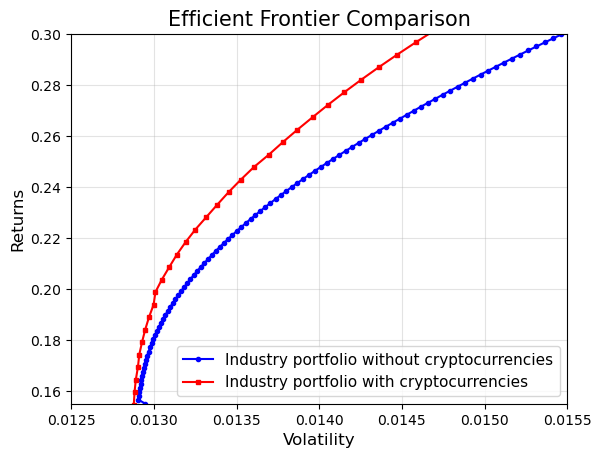

In [7]:
ind_crypto_spliced = ind_crypto['2017-10-31':'2021-12-1']

er = util.annualize_rets(ind_crypto_spliced, periods_per_year)
cov = ind_crypto_spliced.cov()

plot = plotting_functions.plot_ef(
er[industry], cov.loc[industry, industry], 
er[industry_and_crypto], 
cov.loc[industry_and_crypto, industry_and_crypto],
xlim=(0.0125, 0.0155),
ylim=(0.155, 0.3)
)

plt.savefig("../Reports/Figures/Efficient_Frontier_Comparison_Bull_Market.png")

plt.show()

#### Plotting frontier with High volatility equity market with large negative drawdowns

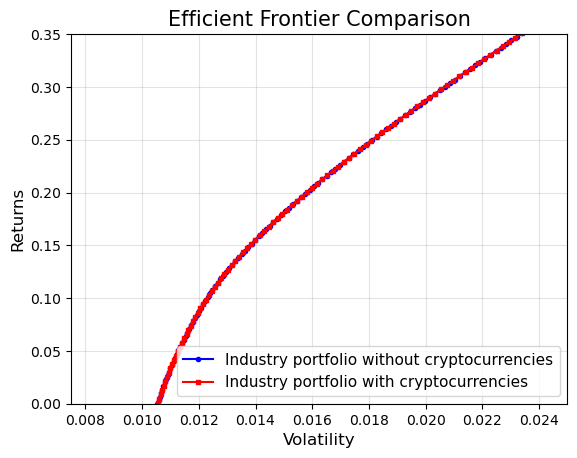

In [8]:
ind_crypto_spliced = ind_crypto['2021-12-1':'2023-10-31']

er = util.annualize_rets(ind_crypto_spliced, periods_per_year)
cov = ind_crypto_spliced.cov()

plot = plotting_functions.plot_ef(
er[industry], cov.loc[industry, industry], 
er[industry_and_crypto], 
cov.loc[industry_and_crypto, industry_and_crypto],
xlim=(0.0075, 0.025),
ylim=(0.0, 0.35))

plt.savefig("../Reports/Figures/Efficient_Frontier_Comparison_Drawdown_Market.png")

plt.show()

### Interactive ipywidgets efficient frontier plot

This is an interactive widget where the reader can choose the desired timeframe
* Keep in mind, <span style="color:crimson"> the earliest available date is 2017-10-31 </span>
* For better interpretability, please adjust the plot limits accordingly in the defined function named `plot_efficient_frontier_widget` which is located inside src\visualization\plotting_functions.py

In [9]:
# Widgets
start_date_widget = widgets.DatePicker(description='Start Date', value=pd.to_datetime('2017-10-31'))
end_date_widget = widgets.DatePicker(description='End Date', value=pd.to_datetime('2023-10-31'))

def update_plot(start_date, end_date):
    plotting_functions.plot_efficient_frontier_widget(start_date=start_date, end_date=end_date, ind_crypto=ind_crypto)

interactive_plot = widgets.interactive(
    update_plot,
    start_date=start_date_widget,
    end_date=end_date_widget
)

display(interactive_plot)

interactive(children=(DatePicker(value=Timestamp('2017-10-31 00:00:00'), description='Start Date', step=1), Da…